# Assignment 4

## Heating a square plate
Consider a square plate with sides $[−1,1]\times[−1,1]$. At time $t = 0$ we are heating the plate up such that the temperature is $u=5$ on one side and $u=0$ on the other sides. The temperature evolves according to: $$\frac{du}{dt}=u_t=\Delta u=\nabla^2u$$
At what time $t^∗$ does the plate reach $u=1$ at the center of the plate?

Implement a finite difference scheme and try with explicit and implicit time-stepping. Numerically investigate the stability of your schemes.

By increasing the number of discretisation points demonstrate how many correct digits you can achieve. Also, plot the convergence of your computed time $t^∗$ against the actual time.

To 12 digits the wanted solution is $t∗=0.424011387033$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy as sp
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

import numba
from numba import cuda, njit, jit

from tqdm import tqdm
from timeit import timeit

In [2]:
def plot3d(u):
  '''
  Plots a 3D plot of the surface u

  Input
  u - some NxN array

  Outputs
  A 3D plot of the surface u
  '''
  uside = int(len(u)**0.5)
  u = u.reshape((uside, uside))
  x = np.linspace(-1, 1, uside)
  X, Y = np.meshgrid(x, x)

  fig = plt.figure(figsize=(9, 5))
  ax = fig.add_subplot(111, projection='3d')

  # Surface plot
  surf = ax.scatter(X, Y, u, c=u.flatten(), cmap='RdBu_r', edgecolor='none')
  ax.set_xlabel('x-axis')
  ax.set_ylabel('y-axis')
  ax.set_zlabel('Temperature (u)')
  ax.set_title('Temperature Distribution on the Plate')
  fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)  # Add color bar

  plt.show()
  return

## Explicit time-stepping - Forward Euler
The heat distribution on the plate is described by the 2D heat equation:
$$
\frac{du}{dt}=\Delta u=\nabla^2 u=\frac{\partial^{2}u}{\partial x^{2}}+\frac{\partial^2u}{\partial y^2}
$$

Our surface $u$ is initialised at $t=0$ with heat applied along just $x=0$ giving the initial conditions:
$$
u(0, y, 0) = 5
$$

where $u(x, y,t)$ represents the temperature at position $(x, y)$ and time $t$, and $\nabla^2u$ is the Laplacian operator.

By discretising the plate into an $(N+1)\times(N+1)$ grid (points $0 \rightarrow N$), we can approximate the Laplacian using the method of finite differences:
$$
\Delta u=\nabla^2u \approx \frac{u_{i,j+1}+u_{i,j-1}+u_{i+1,j}+u_{i-1, j}-4u_{i, j}}{h^2}
$$

which applies to the interior points $i,j=1,2,…,N−1$ and we let $h=\frac{L}{N}=\frac{2}{N}.$

To compute the time evolution of the temperature, we discretise time using the time step $dt$. Using the forward Euler method, the time derivative of the temperature $\frac{\partial u}{\partial t}$ can be approximated as:
$$
\frac{\partial u}{\partial t}\approx\frac{u^{t+1}_{i,j}-u^{t}_{i,j}}{dt}
$$

By rearranging for $u^{t+1}_{i,j}$ we get:
$$
u^{t+1}_{i,j}=dt\cdot\nabla^2u^{t}_{i,j}+u^{t}_{i,j}
$$

The discrete Laplacian operator can be represented as a sparse matrix $A$ acting on the vectorised form of $u^{n}$ if we let:
* $\vec u$ be the flattened temperature values at all grid points at time step
* $A$ be the sparse matrix representing the finite difference Laplacian.

The spatial discretisation can then be written as:
$$
A\vec u=\nabla^2u
$$

and substituting this into the time-stepping equation gives:
$$
u(t+1)=dt\cdot\mathbf{A}\vec u(t)+\vec u(t)
$$

In the following code cells we set up functions to explicitly update the temperature $u(t)$ by calculating the temperature at every timepoint $dt$.

`buildAu` generates the sparse matrix $A$ and the dense 1-$D$ vector $\vec u$, with sizes $((N+1)\times(N+1))$ and $(N+1)$ respectively. We generate $A$  by generating the diagonals and then using `scipy.diags` to format it as a csr matrix.

`xp_solver` carries out the explicit iterative time-stepping method by calling the functions `xptime_step` and `jit_matvec` to carry out the `jit`-accelerated csr matrix vector multiplication.

In [3]:
def buildAu(N):
  '''
  Constructs the sparse matrix A and the initial temperature vector u for solving
  the 2D heat equation on a square plate using finite difference methods.

  Inputs
  N - number of divisions along one side of the square plate
      grid size will be (N+1) x (N+1), and the spatial step size is h = 2/N.

  Outputs
  A - sparse matrix representing the finite difference Laplacian operator for the grid.
        The shape of A is ((N+1)^2, (N+1)^2), corresponding to the flattened grid.
  uvec - 1D vector representing the initial temperature distribution of the grid.
        Boundary conditions are applied, with the left edge (x = -1) set to 5.
  '''

  if N%2 == 1:
    print('Adding 1 to make things work :)')
    N+=1

  msize = (N+1)**2

  # Setting up u plane
  uplane = np.zeros((N+1, N+1))

  # Set boundary condition at x = -1
  uplane[:, 0] = 5

  # Start creating the diagonals for the sparse matrix A
  central_diag = np.zeros(N+2)
  up_diag = np.zeros(N+2)
  down_diag = np.zeros(N+1)
  down_down_diag = np.zeros(1)

  for i in range(N-1):
      add = np.append((-4*np.ones(N-1)), (np.zeros(2)))
      central_diag = np.append(central_diag, add)

  print('Generating arrays')
  for i in tqdm(range(N-1)):
      add = np.append((np.ones(N-1)), (np.zeros(2)))
      up_diag = np.append(up_diag, add)
      down_diag = np.append(down_diag, add)
      down_down_diag = np.append(down_down_diag, add)

  central_diag= np.append(central_diag, np.zeros(N))
  up_diag = np.append(up_diag, np.zeros(N))
  down_diag = np.append(down_diag, np.zeros(N))
  down_down_diag=np.append(down_down_diag, np.zeros(N))

  # Define the positions of the diagonals
  diagonals = [central_diag, up_diag, down_diag, up_diag, down_down_diag ]
  offsets = [0, 1, -1, (N+1), -(N+1)]

  # Generate the sparse matrix using scipy.diags
  A = diags(diagonals, offsets, shape=(msize, msize), format="csr")

  # Flatten the initial temperature plane into a vector
  uvec = uplane.flatten()

  return A, uvec

center_limit = 1

Adding 1 to make things work :)
Generating arrays


100%|██████████| 5/5 [00:00<00:00, 4599.02it/s]


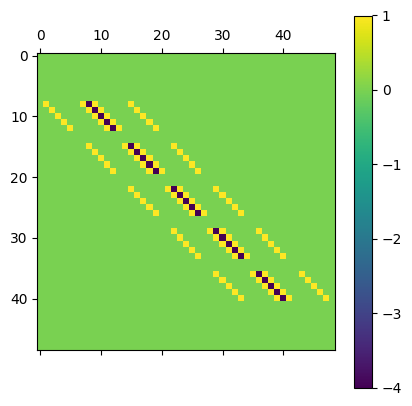

Generating arrays


100%|██████████| 999/999 [00:02<00:00, 497.27it/s]


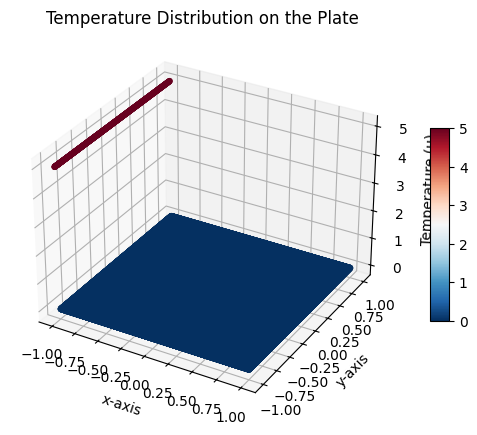

In [4]:
# Testing matrix shapes for correct outputs

plt.matshow(buildAu(5)[0].toarray())
plt.colorbar()
plt.show()
# Expecting a 36 x 36 matrix

testA,testU = buildAu(1000)
plot3d(testU)

### JIT accelerated matvec

In [ ]:
def xptime_step(A, u):
  result = jit_matvec(A.data, A.indices, A.indptr, u)
  return result+u

@njit
def jit_matvec(data, indices, indptr, vector):
  '''
  Compute the matrix vector multiplication for a CSR matrix

  Inputs
  data - non-zero elements in the CSR matrix
  indices - column indices corresponding to data
  indptr - index pointers
  vector - dense vector to multiply matrix with
  rows - number of rows in the CSR matrix

  Outputs
  output - output vector from the calculation
  '''
  rows = len(vector)
  # Initialise the output vector
  output = np.zeros(rows, dtype=data.dtype)

  # Iterate over each row of the sparse matrix
  for row in range(rows):
      col_start = indptr[row]
      col_end = indptr[row + 1]

      # Iterate over non-zero elements
      for col_ind in range(col_start, col_end):
          # Multiply matrix value with the corresponding vector value
          output[row] += (data[col_ind] * vector[indices[col_ind]])
  return output


def xp_solver(N, dt, Tstop):
  '''
  Inputs
  N - The number of spatial grid points
  dt - The time step
  Tstop - The total simulation time

  Outputs
  u - The final state of the system or when the stopping condition is met
  t - Time at which simulation stopped
  '''
  h = 2/N
  A, u = buildAu(N)

  assert (dt/(h**2))<=0.25

  Adt = dt*A*(h**-2)

  t = 0
  counter = 0
  with tqdm(total=int(Tstop / dt), desc="JIT simulation Progess") as pbar:
    while t < Tstop:

      u = xptime_step(Adt, u)
      center = u[int(len(u)/2)]

      if center > center_limit:
          return u, t
      t += dt
      counter+=1
      pbar.update(1) # Update progress bar

  return u, Tstop

In [ ]:
N = 100
dt = 1e-6
T = 0.5
u , ts= xp_solver(N,dt,T)
print(f'\nCenter temperature {u[int(len(u)/2)]} reached at: {ts}')

Generating arrays


100%|██████████| 99/99 [00:00<00:00, 12369.63it/s]



 0.0025


JIT simulation Progess:  85%|████████▍ | 424011/500000 [00:35<00:06, 11875.62it/s]


Center temperature 1.0000003861979303 reached at:0.42401099999557357


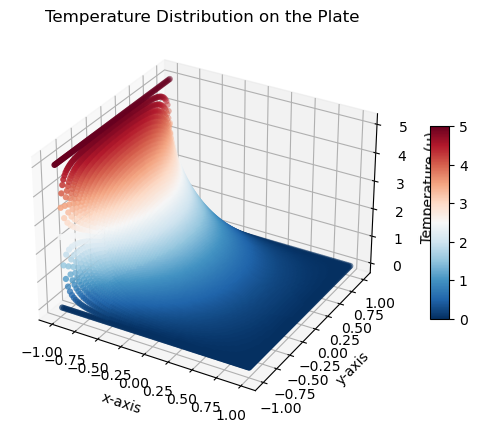

In [ ]:
plot3d(u)

In [ ]:
Nlist = np.arange(10, 110, 10)
jittimes = []
for i in Nlist:
  jittiming = timeit(lambda: xp_solver(i, dt, T), number=1)
  jittimes.append(jittiming)

Generating arrays


100%|██████████| 9/9 [00:00<?, ?it/s]



 2.4999999999999994e-05


JIT simulation Progess:  85%|████████▍ | 424108/500000 [00:01<00:00, 260106.99it/s]


Generating arrays


100%|██████████| 19/19 [00:00<00:00, 18969.72it/s]



 9.999999999999998e-05


JIT simulation Progess:  85%|████████▍ | 424041/500000 [00:02<00:00, 151088.60it/s]


Generating arrays


100%|██████████| 29/29 [00:00<00:00, 28823.42it/s]



 0.000225


JIT simulation Progess:  85%|████████▍ | 424024/500000 [00:04<00:00, 91990.99it/s]


Generating arrays


100%|██████████| 39/39 [00:00<00:00, 38947.11it/s]



 0.0003999999999999999


JIT simulation Progess:  85%|████████▍ | 424018/500000 [00:06<00:01, 62050.95it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 24516.39it/s]



 0.000625


JIT simulation Progess:  85%|████████▍ | 424015/500000 [00:10<00:01, 39193.11it/s]


Generating arrays


100%|██████████| 59/59 [00:00<00:00, 19832.02it/s]



 0.0009


JIT simulation Progess:  85%|████████▍ | 424014/500000 [00:14<00:02, 29152.33it/s]


Generating arrays


100%|██████████| 69/69 [00:00<00:00, 34523.08it/s]



 0.001225


JIT simulation Progess:  85%|████████▍ | 424013/500000 [00:19<00:03, 22038.25it/s]


Generating arrays


100%|██████████| 79/79 [00:00<00:00, 39028.27it/s]



 0.0015999999999999996


JIT simulation Progess:  85%|████████▍ | 424012/500000 [00:27<00:04, 15589.91it/s]


Generating arrays


100%|██████████| 89/89 [00:00<00:00, 29692.42it/s]



 0.002025


JIT simulation Progess:  85%|████████▍ | 424012/500000 [00:30<00:05, 13861.23it/s]


Generating arrays


100%|██████████| 99/99 [00:00<00:00, 32871.76it/s]



 0.0025


JIT simulation Progess:  85%|████████▍ | 424011/500000 [00:34<00:06, 12242.62it/s]


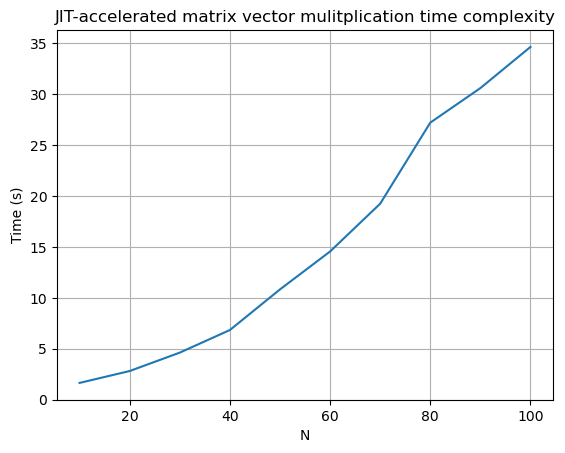

In [ ]:
plt.plot(Nlist, jittimes)
plt.ylabel('Time (s)')
plt.xlabel('N')
plt.title('JIT-accelerated matrix vector mulitplication time complexity')
plt.grid()

#### Discussion
For low values of $N$, the calculation is pretty fast reaching speeds ~100,000 iterations per second for N=10, but quickly slows down as $N$ increases. The time complexity of the function w.r.t $N$ is roughly linear.

### CUDA acceleration for explicit time-steppping
Here we accelerate the `matvec` by parsing the calculation to a CUDA kernel. The `xp_solver_cuda` function solves the 2D heat equation using a sparse matrix-vector multiplication approach entirely on the GPU.

This kernel computes one explicit time step per calculation.
For each row of the matrix, it calculates the dot product of the row's non-zero elements with the corresponding entries in the current temperature vector.

The loop performs a series of time steps until the simulation time `t` reaches `Tstop` or the center grid temperature exceeds 1.
The temperature values are updated entirely on the GPU, with intermediate results transferred to the host only for monitoring the center grid value.

In [5]:
@cuda.jit
def matvec_cuda(data, indices, indptr, vector, output):
  '''
  CUDA kernel to compute one explicit time step for the 2D heat equation.

  Inputs
  data - Non-zero elements in the CSR matrix (Laplacian operator)
  indices - Column indices corresponding to data
  indptr - Row pointer indices for CSR format
  vector - Temperature values at the current time step (u^n)
  output - Temperature values at the next time step (u^{n+1})
  '''
  # Get the global thread index (1D grid)
  row = cuda.grid(1)

  cuda.syncthreads()

  if row < vector.shape[0]:
    # Perform sparse matrix-vector multiplication for this row
    col_start = indptr[row]
    col_end = indptr[row + 1]

    laplacian_sum = 0.0
    for col_ind in range(col_start, col_end):
        laplacian_sum += data[col_ind] * vector[indices[col_ind]]

    cuda.syncthreads()

    # Update temperature using the time-stepping equation
    output[row] = vector[row] + laplacian_sum
    output = vector

# Host-side code
def xp_solver_cuda(N, dt, Tstop):
  '''
  Solve the 2D heat equation using sparse matrix-vector multiplication entirely on the GPU
  with batching to limit CPU-GPU communication.

  Inputs
  N - Grid size
  dt - Time step size
  Tstop - Simulation stop time
  steps_per_kernel - Number of timesteps to process in one kernel launch

  Outputs
  u - Final temperature distribution
  t - Time at which the simulation stopped
  '''
  h = 2/N
  assert (dt/(h**2))<=0.25
  
  # Initialize the grid and solution vector
  A, u = buildAu(N)
  unew = np.copy(u)  # Vector for updated temperatures
  Adt = dt*A*(h**-2)

  # Allocate memory on the GPU
  A_data_d = cuda.to_device(Adt.data)
  A_indices_d = cuda.to_device(Adt.indices)
  A_indptr_d = cuda.to_device(Adt.indptr)
  u_d = cuda.to_device(u)
  unew_d = cuda.to_device(unew)

  num_rows = (N+1)**2
  threads_per_block = num_rows//32
  blocks_per_grid = min(256, (num_rows + threads_per_block)//threads_per_block)*16

  # Time-stepping loop
  t = 0
  with tqdm(total=int(Tstop / dt), desc="CUDA Progress") as pbar:
    while t < Tstop:
      # Perform sparse matrix-vector multiplication (SpMV) and update u directly on the GPU
      matvec_cuda[blocks_per_grid, threads_per_block](A_data_d, A_indices_d, A_indptr_d, u_d, unew_d)

      # Swap u and unew for the next batch of timesteps
      u_d, unew_d = unew_d, u_d

      if t>0.42:
        center = u_d[int(len(u)/2)]

        if center > center_limit:
            return u_d.copy_to_host(), t
      # Update time
      t += dt
      pbar.update(1)

  # Copy the final result back to the host
  u = u_d.copy_to_host()  # Transfer data back to CPU memory
  return u, t

In [6]:
N = 100  # Grid size
dt = 1e-6
Tstop = 0.5

final_temperature, final_time = xp_solver_cuda(N, dt, Tstop)
print(f"\nSimulation stopped at time {final_time} with mid temp {final_temperature[int(len(final_temperature)/2)]}")

Generating arrays


CUDA Progress:  85%|████████▍ | 424011/500000 [00:35<00:06, 12080.69it/s]


Simulation stopped at time 0.42401099999557357 with mid temp 1.0000003861979303


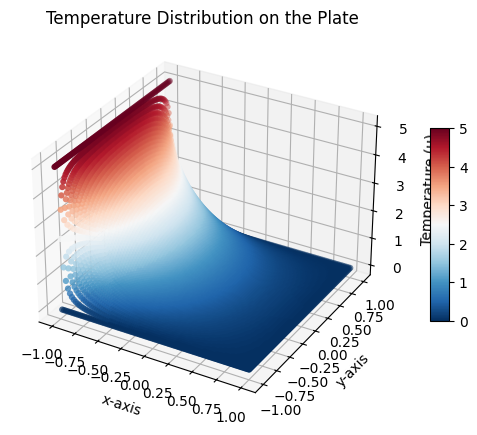

In [7]:
plot3d(final_temperature)

In [13]:
Nlist = np.arange(10, 110, 10)
dt =1e-6
T=0.5
cudatimes = []
for i in Nlist:
  cudatiming = timeit(lambda: xp_solver_cuda(i, dt, T), number=1)
  cudatimes.append(cudatiming)

Generating arrays


CUDA Progress:  85%|████████▍ | 424108/500000 [00:34<00:06, 12168.63it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 424041/500000 [00:34<00:06, 12220.24it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 424024/500000 [00:34<00:06, 12224.82it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 424018/500000 [00:34<00:06, 12230.81it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 424015/500000 [00:34<00:06, 12192.23it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 424014/500000 [00:35<00:06, 12061.31it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 424013/500000 [00:35<00:06, 12109.53it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 424012/500000 [00:35<00:06, 12098.00it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 424012/500000 [00:35<00:06, 12081.74it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 424011/500000 [00:34<00:06, 12288.28it/s]


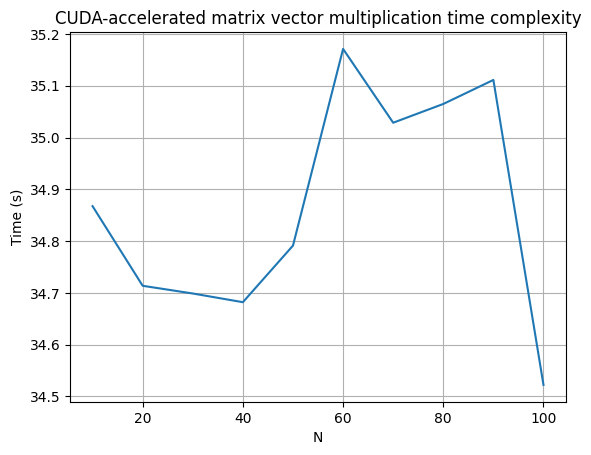

In [15]:
plt.plot(Nlist, cudatimes)
plt.ylabel('Time (s)')
plt.xlabel('N')
plt.title('CUDA-accelerated matrix vector multiplication time complexity')
plt.grid()

#### Discussion
The time complexity of the CUDA accelerated matrix vector implementation is roughly steady at ~$34s$ regardless of how big $N$ is due to how the `matvec` operation is parallelised in the GPU. Unfortunately there is a size limitation on $N$ and this function doesn't work above $N=200$ for some reason. This could be due to the issue that for $N=200$ we require $N^2$ threads in the GPU to parallelise our operation and so there aren't enough threads.

The only other processing overheads are from communications between the CPU and the GPU and so we incur some processing between each matrix vector mulitplication. Where we decrease $dt$ and so increase the number of discretisations in time, the time complexity of `xp_solver_cuda` becomes linear w.r.t dt.

## Batched CUDA matvec
This section of code outlines a version of the CUDA accelerated matrix vector multiplication that instead of returning the results to the CPU after each calculation, does maybe 100 or 1000 matrix vector calculations in a row and then returns the results to the CPU. This is much, much faster as we can get rid of the communication overheads involved in updating the CPU.

In [ ]:
@cuda.jit
def matvec_cuda_batch(data, indices, indptr, vector, output, inner_steps):
  '''
  CUDA kernel to compute one explicit time step for the 2D heat equation.

  Inputs
  data - Non-zero elements in the CSR matrix (Laplacian operator)
  indices - Column indices corresponding to data
  indptr - Row pointer indices for CSR format
  vector - Temperature values at the current time step (u^n)
  output - Temperature values at the next time step (u^{n+1})
  '''
  # Get the global thread index (1D grid)
  row = cuda.grid(1)

  cuda.syncthreads()
  counter = 0

  while counter <= inner_steps:
    if row < vector.shape[0]:
      # Perform sparse matrix-vector multiplication for this row
      col_start = indptr[row]
      col_end = indptr[row + 1]

      laplacian_sum = 0.0
      for col_ind in range(col_start, col_end):
          laplacian_sum += data[col_ind] * vector[indices[col_ind]]

      cuda.syncthreads()

      # Update temperature using the time-stepping equation
      output[row] = vector[row] + laplacian_sum
      cuda.syncthreads()
    output = vector
    counter += 1

def xp_solver_cuda_batch(N, dt, Tstop):
  '''
  Solve the 2D heat equation using sparse matrix-vector multiplication entirely on the GPU
  with batching to limit CPU-GPU communication.

  Inputs
  N - Grid size
  dt - Time step size
  Tstop - Simulation stop time
  steps_per_kernel - Number of timesteps to process in one kernel launch

  Outputs
  u - Final temperature distribution
  t - Time at which the simulation stopped
  '''
  h = 2/N
  assert (dt/(h**2))<=0.25
  
  # Initialize the grid and solution vector
  A, u = buildAu(N)
  unew = np.copy(u)  # Vector for updated temperatures
  Adt = dt*A*(h**-2)

  # Allocate memory on the GPU
  A_data_d = cuda.to_device(Adt.data)
  A_indices_d = cuda.to_device(Adt.indices)
  A_indptr_d = cuda.to_device(Adt.indptr)
  u_d = cuda.to_device(u)
  unew_d = cuda.to_device(unew)

  num_rows = (N+1)**2
  threads_per_block = num_rows//32
  blocks_per_grid = min(256, (num_rows + threads_per_block)//threads_per_block)*16

  inner_steps = 10000
  # Time-stepping loop
  t = 0
  with tqdm(total=int(Tstop / dt), desc="Batched CUDA Progress") as pbar:
    while t < Tstop:
      # Perform sparse matrix-vector multiplication (SpMV) and update u directly on the GPU
      matvec_cuda_batch[blocks_per_grid, threads_per_block](A_data_d, A_indices_d, A_indptr_d, u_d, unew_d, inner_steps)

      # Swap u and unew for the next batch of timesteps

      if t>0.42:
        inner_steps=10
        center = u_d[int(len(u)/2)]

        if center > center_limit:
            return u_d.copy_to_host(), t
      # Update time
      t += dt*inner_steps
      pbar.update(inner_steps)

  # Copy the final result back to the host
  u = u_d.copy_to_host()  # Transfer data back to CPU memory
  return u, t

In [ ]:
N = 150  # Grid size
dt = 1e-8
print((2/N)**2*dt)
Tstop = 0.5

stop_testu, final_time = xp_solver_cuda_batch(N, dt, Tstop)

1.7777777777777782e-12
Generating arrays


Batched CUDA Progress:  90%|████████▉ | 44796660/50000000 [02:50<00:19, 262711.20it/s]



Simulation stopped at time 0.4479666000007714 with mid temp 1.0000000498380361


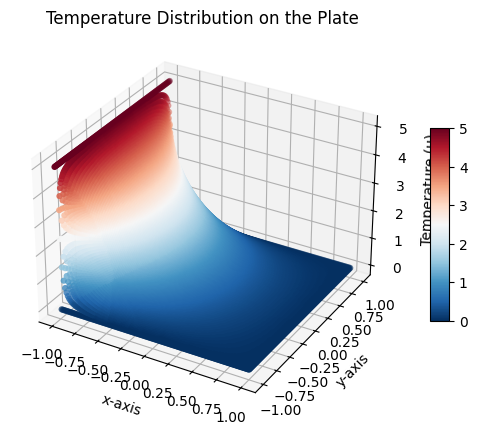

In [ ]:
print(f"\nSimulation stopped at time {final_time} with mid temp {stop_testu[int(len(stop_testu)/2)]}")
plot3d(stop_testu)

#### Discussion
This batched version of CUDA is extremely fast completing very large matrices N=150 with t=1e-9 in minutes, where the equivalent simulation using `xp_solver_cuda` would take $15-20$ minutes but for some reason it carries along massive errors. From what I can find, it's due to floating point errors accumulating in the CUDA kernel which aren't caught out by the CPU which is what happens in regular CUDA accelerated explicit time stepping method.

## The implicit solution - Backwards Euler
The backward Euler equation is given as: $$\frac{du}{dt}=\frac{u_n-u_{n-1}}{\Delta t}$$

which in matrix form is:
$$
f(U_{n+1}, t_{n_1})=\frac{U_{n+1}-U_n}{\Delta t}
$$

This can be rearranged to give:
$$
U_{n+1} = U_n\cdot (1 - dt\cdot f(U_{n+1},\space t_{n+1}))
$$

By rearranging the equations, we can get :
$$
(I-\Delta t \cdot A) u^{t+1}=u^t
$$

where $I$ is the identity matrix and $A$ has the same discretised Laplacian form from the previous explicit part.

If we let $B=(I-\Delta t\cdot A)$ the equation then becomes:
$$
B\cdot u^{u+1}=u^t
$$

which can then be solved as a matrix problem of the form $Ax=B$. For the example where $dt=0.1$ each solve of $B\cdot u^{u+1}=u^t$ will result in finding the temperature at $0.1n\space s$ further in time.

Adding 1 to make things work :)
Generating arrays


100%|██████████| 5/5 [00:00<00:00, 6295.86it/s]


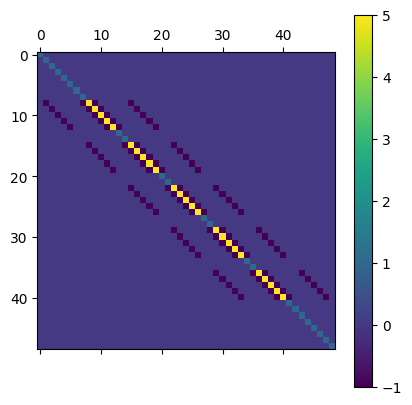

In [ ]:
def buildAuimplicit(N, hinvdt):
  '''
  Constructs the sparse matrix A and the initial temperature vector u for solving
  the 2D heat equation using finite difference methods.
  This is the implicit solution method and so the resulting matrix A has
  a different shape compared to that from buildAu

  Inputs
  N - The number of divisions along one side of the square plate (default is 10).
        The grid size will be (N+1) x (N+1), and the spatial step size is h = 2/N.

  Outputs
  A - sparse matrix representing the finite difference Laplacian operator for the grid.
        The shape of A is ((N+1)^2, (N+1)^2), corresponding to the flattened grid.
  uvec - 1D vector representing the initial temperature distribution of the grid.
              Boundary conditions are applied, with the left edge (x = -1) set to 5.
  '''
  if N%2 == 1:
    print('Adding 1 to make things work :)')
    N+=1
  msize = (N+1)**2

  # Setting up u plane
  uplane = np.zeros((N+1, N+1))

  # Boundary condition at x = -1
  uplane[:, 0] = 5

  # Create the diagonals for the sparse matrix A
  central_diag = np.zeros(N+2)
  up_diag = np.zeros(N+2)
  down_diag = np.zeros(N+1)
  down_down_diag = np.zeros(1)

  for i in range(N-1):
      add = np.append((-4*np.ones(N-1)), (np.zeros(2)))
      central_diag = np.append(central_diag, add)

  print('Generating arrays')
  for i in tqdm(range(N-1)):
      add = np.append((np.ones(N-1)), (np.zeros(2)))
      up_diag = np.append(up_diag, add)
      down_diag = np.append(down_diag, add)
      down_down_diag = np.append(down_down_diag, add)

  central_diag= np.append(central_diag, np.zeros(N))
  up_diag = np.append(up_diag, np.zeros(N))
  down_diag = np.append(down_diag, np.zeros(N))
  down_down_diag=np.append(down_down_diag, np.zeros(N))

  # Define the positions of the diagonals
  diagonals = [central_diag, up_diag, down_diag, up_diag, down_down_diag ]
  offsets = [0, 1, -1, (N+1), -(N+1)]

  # Generate the sparse matrix using scipy.sparse.diags
  A = diags(diagonals, offsets, shape=(msize, msize), format="csr")

  I = sp.sparse.identity(msize, dtype='int8', format='csr')

  # Flatten the initial temperature plane into a vector
  uvec = uplane.flatten()

  return (I-hinvdt*A), uvec
plt.matshow(buildAuimplicit(5, 1)[0].toarray())
plt.colorbar()
plt.show()

In [ ]:
def implicit_solve(N, dt, Tstop):
  '''
  Solves a system using an implicit time-stepping method for a given duration.

  Inputs
  N - number of grid points in the simulation
  dt - time step size
  Tstop - total simulation

  Outputs
  u - final state of the system at the end of the simulation
  time - time at which the simulation stopped, at Tstop or when condition satisfied.
  '''
  h=2/N
  h_inv2 = h**-2

  time = 0

  A1, u = buildAuimplicit(N, h_inv2*dt)

  for i in tqdm(range(int(Tstop/dt))):
    u = spsolve(A1,u)
    mid_temp = u[int(len(u)/2)]
    if mid_temp > center_limit:
      break
    time += dt
  return u, time

Generating arrays


 85%|████████▍ | 42405/49999 [00:44<00:07, 950.78it/s]


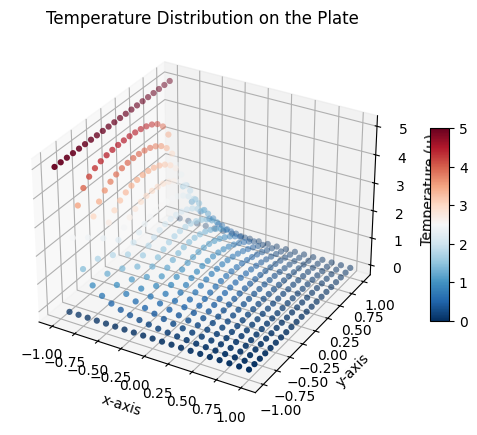

In [ ]:
u, time = implicit_solve(20, 1e-5, 0.5, 0.42)
plot3d(u)

In [ ]:
print(f'Center temp {u[int(len(u)/2)]}, at time {time}')

Center temp 1.0000083076755566, at time 0.4240500000002833


## Comparing the methods

In [ ]:
dislist = np.arange(20, 101, 20)
print(dislist)

[ 20  40  60  80 100]


In [ ]:
dt = 1e-7
Tstop = 0.5
jitmatvectime = []
jitmatvecsol = []

for i in dislist:
  jitsolu, jitsolt = xp_solver(i, dt, Tstop)
  jitmatvectime.append(jitsolt)
  jitmatvecsol.append(jitsolu)

Generating arrays


100%|██████████| 19/19 [00:00<00:00, 21661.26it/s]



 9.999999999999997e-06


JIT simulation Progess:  85%|████████▍ | 4240427/5000000 [00:37<00:06, 111926.28it/s]


Generating arrays


100%|██████████| 39/39 [00:00<00:00, 18795.57it/s]



 3.999999999999999e-05


JIT simulation Progess:  85%|████████▍ | 4240195/5000000 [01:48<00:19, 38909.63it/s]


Generating arrays


100%|██████████| 59/59 [00:00<00:00, 31420.00it/s]



 8.999999999999999e-05


JIT simulation Progess:  85%|████████▍ | 4240149/5000000 [03:36<00:38, 19578.72it/s]


Generating arrays


100%|██████████| 79/79 [00:00<00:00, 33429.18it/s]



 0.00015999999999999996


JIT simulation Progess:  85%|████████▍ | 4240133/5000000 [06:05<01:05, 11589.53it/s]


Generating arrays


100%|██████████| 99/99 [00:00<00:00, 39273.25it/s]



 0.00025


JIT simulation Progess:  85%|████████▍ | 4240126/5000000 [09:35<01:43, 7372.71it/s]


In [ ]:
cudamatvectime = []
cudamatvecsol = []

for i in dislist:
  print(i)
  cudasolu, cudasolt = xp_solver_cuda(i, dt, Tstop)
  cudamatvectime.append(cudasolt)
  cudamatvecsol.append(cudasolu)

20
Generating arrays


CUDA Progress:  85%|████████▍ | 4240427/5000000 [05:44<01:01, 12299.13it/s]


40
Generating arrays


CUDA Progress:  85%|████████▍ | 4240195/5000000 [05:44<01:01, 12321.67it/s]


60
Generating arrays


CUDA Progress:  85%|████████▍ | 4240149/5000000 [05:43<01:01, 12342.75it/s]


80
Generating arrays


CUDA Progress:  85%|████████▍ | 4240133/5000000 [05:43<01:01, 12361.65it/s]


100
Generating arrays


CUDA Progress:  85%|████████▍ | 4240126/5000000 [05:43<01:01, 12350.28it/s]


In [ ]:
batchmatvectime = []
batchmatvecsol = []

for i in dislist:
  batchsolu, batchsolt = xp_solver_cuda_batch(i, dt, Tstop)
  batchmatvectime.append(batchsolt)
  batchmatvecsol.append(batchsolu)

Generating arrays


Batched CUDA Progress:  89%|████████▉ | 4458070/5000000 [00:06<00:00, 671342.78it/s]


Generating arrays


Batched CUDA Progress:  93%|█████████▎| 4663560/5000000 [00:10<00:00, 428199.89it/s]


Generating arrays


Batched CUDA Progress:  98%|█████████▊| 4884230/5000000 [00:15<00:00, 310815.93it/s]


Generating arrays


100%|██████████| 79/79 [00:00<00:00, 29408.89it/s]
Batched CUDA Progress: 5000010it [00:20, 249568.06it/s]                            


Generating arrays


100%|██████████| 99/99 [00:00<00:00, 48571.31it/s]
Batched CUDA Progress: 5000010it [00:22, 225033.11it/s]                            


In [ ]:
implicittime = []
implicittemp = []

for i in dislist:
  print(f'{i}\n ')
  impsolu, impsolt = implicit_solve(i, dt, Tstop)

  implicittime.append(impsolt)
  implicittemp.append(impsolu)

20
 
Generating arrays


 85%|████████▍ | 42405/49999 [00:44<00:07, 950.96it/s]


40
 
Generating arrays


 85%|████████▍ | 42403/49999 [03:10<00:34, 222.51it/s]


60
 
Generating arrays


 85%|████████▍ | 42402/49999 [07:55<01:25, 89.21it/s]


80
 
Generating arrays


 85%|████████▍ | 42402/49999 [15:56<02:51, 44.34it/s]


100
 
Generating arrays


 85%|████████▍ | 42402/49999 [28:17<05:04, 24.98it/s]


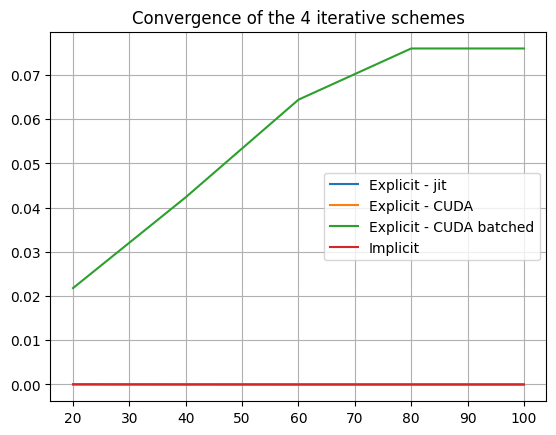

In [ ]:
actual_t = 0.424011387033

errorjit = np.abs(np.array(jitmatvectime)-actual_t)
errorcuda = np.abs(np.array(cudamatvectime)-actual_t)
errorbatch = np.abs(np.array(batchmatvectime)-actual_t)
errorimplicit = np.abs(np.array(implicittime)-actual_t)

plt.plot(dislist, errorjit, label='Explicit - jit')
plt.plot(dislist, errorcuda, label='Explicit - CUDA')
plt.plot(dislist, errorbatch, label='Explicit - CUDA batched')
plt.plot(dislist, errorimplicit, label='Implicit')
plt.title('Convergence of the 4 iterative schemes')
plt.legend()
plt.grid()
plt.show()

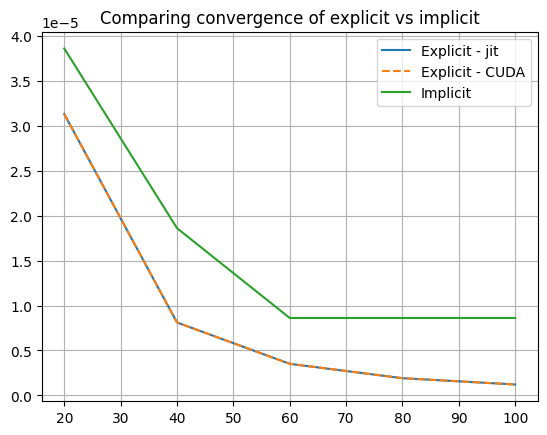

In [ ]:
plt.plot(dislist, errorjit, ls='-', label='Explicit - jit')
plt.plot(dislist, errorcuda, ls='--', label='Explicit - CUDA')
plt.plot(dislist, errorimplicit, label='Implicit')
plt.title('Comparing convergence of explicit vs implicit')
plt.legend()
plt.grid()
plt.show()

#### Discussion
We can clearly see from the above plot of error vs N, that the CUDA-batched version of the `matvec` multiplication carries bigger errors compared to all other methods, and overall all the methods converge to $t^*=0.424011387033$ as the space discretisation increases ($N$ increases), apart from the CUDA-batched method which appears to diverge as $N$ increases.

As we look more closely at just explicit vs implicit methods, it is clear that the explicit method converges better to $t^*$ compared to the implicit method. The `jit` and CUDA explicit methods return the exact same results as they employ the same maths "under the hood".

In terms of speed, the `jit` compiled version is faster for small $N$ but as previously discussed the CUDA implementation is more consistent and maintains a constant time of ~$5:40$ and eventually overtakes as the `jit` implementation becomes slower for larger $N$. The CUDA implementation is only really limited by the communication overheads introduced between the GPU and CPU after each iteration.

The slowest implementation is the implicit solver which for $N=100$ takes ~$28:00$ but this is due the problem that solving a linear system of equations at each iteration is computationally very heavy.

In [ ]:
N=50
dtlist = np.logspace(-5, 1, num=200)

stabulist = []

for i in dtlist:
  stabsolu, stabsolt = xp_solver_cuda(N, i, Tstop)
  stabulist.append(stabsolu)

Generating arrays


CUDA Progress:  85%|████████▍ | 42400/50000 [00:03<00:00, 12331.75it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 39556/46646 [00:03<00:00, 12409.92it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 36903/43517 [00:03<00:00, 12089.80it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 34428/40599 [00:02<00:00, 12247.08it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 32119/37876 [00:02<00:00, 12403.20it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 29964/35335 [00:02<00:00, 11997.50it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 27955/32965 [00:02<00:00, 12318.68it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 26080/30754 [00:02<00:00, 12355.81it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 24330/28692 [00:01<00:00, 12349.43it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 22698/26767 [00:01<00:00, 12315.66it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 21176/24972 [00:01<00:00, 12413.49it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 19756/23297 [00:01<00:00, 12274.02it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 18431/21735 [00:01<00:00, 12241.48it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 17194/20277 [00:01<00:00, 12245.66it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 16041/18917 [00:01<00:00, 12296.90it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 14965/17648 [00:01<00:00, 12353.39it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 13961/16464 [00:01<00:00, 12277.35it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 13025/15360 [00:01<00:00, 12456.74it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 12151/14330 [00:00<00:00, 12350.64it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 11336/13369 [00:00<00:00, 12558.03it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 10576/12472 [00:00<00:00, 12321.72it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 9866/11636 [00:00<00:00, 12327.43it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 9204/10855 [00:00<00:00, 12372.50it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 8587/10127 [00:00<00:00, 12286.08it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 8011/9448 [00:00<00:00, 12359.04it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 7474/8814 [00:00<00:00, 12531.61it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 6972/8223 [00:00<00:00, 12466.79it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 6504/7671 [00:00<00:00, 12130.56it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 6068/7157 [00:00<00:00, 12465.59it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 5661/6677 [00:00<00:00, 12216.70it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 5281/6229 [00:00<00:00, 12198.30it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 4927/5811 [00:00<00:00, 12407.80it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 4596/5421 [00:00<00:00, 12405.40it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 4288/5058 [00:00<00:00, 12445.59it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 4000/4718 [00:00<00:00, 12373.10it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 3732/4402 [00:00<00:00, 12417.81it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 3481/4107 [00:00<00:00, 12419.31it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 3248/3831 [00:00<00:00, 12066.49it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 3030/3574 [00:00<00:00, 12219.47it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 2827/3334 [00:00<00:00, 12322.30it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 2637/3111 [00:00<00:00, 12410.99it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 2460/2902 [00:00<00:00, 12007.88it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 2295/2707 [00:00<00:00, 12433.88it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 2141/2526 [00:00<00:00, 12362.56it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 1997/2356 [00:00<00:00, 12307.67it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 1863/2198 [00:00<00:00, 12040.66it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 1738/2051 [00:00<00:00, 11839.14it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 1621/1913 [00:00<00:00, 12209.78it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 1513/1785 [00:00<00:00, 12168.94it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 1411/1665 [00:00<00:00, 12238.89it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 1316/1553 [00:00<00:00, 12228.02it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 1228/1449 [00:00<00:00, 12255.85it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 1145/1352 [00:00<00:00, 12613.04it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 1068/1261 [00:00<00:00, 11623.03it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 990/1177 [00:00<00:00, 12730.08it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 924/1098 [00:00<00:00, 12469.79it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 862/1024 [00:00<00:00, 12013.83it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 804/955 [00:00<00:00, 12332.40it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 750/891 [00:00<00:00, 12455.57it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 700/831 [00:00<00:00, 12378.94it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 652/776 [00:00<00:00, 12126.46it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 610/724 [00:00<00:00, 12392.59it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 568/675 [00:00<00:00, 12535.79it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 530/630 [00:00<00:00, 12202.45it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 494/587 [00:00<00:00, 12062.70it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 462/548 [00:00<00:00, 11963.60it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 430/511 [00:00<00:00, 11573.98it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 402/477 [00:00<00:00, 11292.00it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 376/445 [00:00<00:00, 10854.56it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 350/415 [00:00<00:00, 12049.63it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 326/387 [00:00<00:00, 12031.92it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 304/361 [00:00<00:00, 11738.15it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 284/337 [00:00<00:00, 10953.10it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 266/314 [00:00<00:00, 12093.36it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 248/293 [00:00<00:00, 12004.06it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 232/273 [00:00<00:00, 11283.64it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 216/255 [00:00<00:00, 11427.47it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 202/238 [00:00<00:00, 11260.92it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 188/222 [00:00<00:00, 11559.47it/s]


Generating arrays


CUDA Progress:  85%|████████▌ | 176/207 [00:00<00:00, 11552.75it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 164/193 [00:00<00:00, 11106.07it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 152/180 [00:00<00:00, 11076.57it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 142/168 [00:00<00:00, 11041.53it/s]


Generating arrays


CUDA Progress:  85%|████████▌ | 134/157 [00:00<00:00, 10592.87it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 124/146 [00:00<00:00, 10808.04it/s]


Generating arrays


CUDA Progress:  85%|████████▌ | 116/136 [00:00<00:00, 9218.77it/s]


Generating arrays


CUDA Progress:  85%|████████▌ | 108/127 [00:00<00:00, 10120.53it/s]


Generating arrays


CUDA Progress:  86%|████████▌ | 102/119 [00:00<00:00, 6589.13it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 94/111 [00:00<00:00, 9506.31it/s]


Generating arrays


CUDA Progress:  85%|████████▌ | 88/103 [00:00<00:00, 9673.92it/s]


Generating arrays


CUDA Progress:  85%|████████▌ | 82/96 [00:00<00:00, 10363.80it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 76/90 [00:00<00:00, 9782.63it/s]


Generating arrays


CUDA Progress:  86%|████████▌ | 72/84 [00:00<00:00, 9448.70it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 66/78 [00:00<00:00, 9475.08it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 62/73 [00:00<00:00, 10418.54it/s]


Generating arrays


CUDA Progress:  85%|████████▌ | 58/68 [00:00<00:00, 9446.26it/s]


Generating arrays


CUDA Progress:  86%|████████▌ | 54/63 [00:00<00:00, 6052.71it/s]


Generating arrays


CUDA Progress:  85%|████████▍ | 50/59 [00:00<00:00, 6516.13it/s]


Generating arrays


CUDA Progress:  87%|████████▋ | 48/55 [00:00<00:00, 6168.85it/s]


Generating arrays


CUDA Progress:  86%|████████▋ | 44/51 [00:00<00:00, 8720.38it/s]


Generating arrays


CUDA Progress:  88%|████████▊ | 42/48 [00:00<00:00, 9466.43it/s]


Generating arrays


CUDA Progress:  84%|████████▍ | 38/45 [00:00<00:00, 6012.89it/s]


Generating arrays


CUDA Progress:  86%|████████▌ | 36/42 [00:00<00:00, 7353.41it/s]


Generating arrays


CUDA Progress:  87%|████████▋ | 34/39 [00:00<00:00, 7935.80it/s]


Generating arrays


CUDA Progress:  89%|████████▉ | 32/36 [00:00<00:00, 7436.30it/s]


Generating arrays


CUDA Progress:  88%|████████▊ | 30/34 [00:00<00:00, 7368.34it/s]


Generating arrays


CUDA Progress:  90%|█████████ | 28/31 [00:00<00:00, 7843.49it/s]


Generating arrays


CUDA Progress:  90%|████████▉ | 26/29 [00:00<00:00, 7920.68it/s]


Generating arrays


CUDA Progress:  89%|████████▉ | 24/27 [00:00<00:00, 7780.44it/s]


Generating arrays


CUDA Progress:  96%|█████████▌| 24/25 [00:00<00:00, 6399.45it/s]


Generating arrays


CUDA Progress: 100%|██████████| 24/24 [00:00<00:00, 6695.26it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 27672.13it/s]
CUDA Progress: 23it [00:00, 6602.94it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 34483.37it/s]
CUDA Progress: 21it [00:00, 7583.98it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 60805.00it/s]
CUDA Progress: 20it [00:00, 7381.74it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 25562.30it/s]
CUDA Progress: 19it [00:00, 5838.65it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 20066.48it/s]
CUDA Progress: 18it [00:00, 6249.27it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 15679.04it/s]
CUDA Progress: 16it [00:00, 6318.51it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 23776.13it/s]
CUDA Progress: 15it [00:00, 4852.65it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 21406.20it/s]
CUDA Progress: 14it [00:00, 5566.43it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 61239.84it/s]
CUDA Progress: 13it [00:00, 5225.29it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 24181.77it/s]
CUDA Progress: 13it [00:00, 4467.88it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 53857.68it/s]
CUDA Progress: 12it [00:00, 6607.80it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 26601.20it/s]
CUDA Progress: 11it [00:00, 5898.41it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 45701.78it/s]
CUDA Progress: 10it [00:00, 5682.57it/s]            


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 27773.09it/s]
CUDA Progress: 10it [00:00, 4884.48it/s]            


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 13461.77it/s]
CUDA Progress: 9it [00:00, 4974.79it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 31054.83it/s]
CUDA Progress: 8it [00:00, 4910.64it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 36407.60it/s]
CUDA Progress: 8it [00:00, 4807.23it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 59450.65it/s]
CUDA Progress: 7it [00:00, 3961.16it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 61367.84it/s]
CUDA Progress: 7it [00:00, 4556.90it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 23006.93it/s]
CUDA Progress: 7it [00:00, 3461.87it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 31012.66it/s]
CUDA Progress: 6it [00:00, 3454.95it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 54776.36it/s]
CUDA Progress: 6it [00:00, 4771.68it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 60859.02it/s]
CUDA Progress: 5it [00:00, 3708.49it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 25603.70it/s]
CUDA Progress: 5it [00:00, 3697.38it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 53382.05it/s]
CUDA Progress: 5it [00:00, 3257.96it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 60217.08it/s]
CUDA Progress: 4it [00:00, 3170.30it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 62034.68it/s]
CUDA Progress: 4it [00:00, 3204.82it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 21577.00it/s]
CUDA Progress: 4it [00:00, 2796.20it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 27889.93it/s]
CUDA Progress: 4it [00:00, 2485.88it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 31182.05it/s]
CUDA Progress: 4it [00:00, 2618.98it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 31078.31it/s]
CUDA Progress: 3it [00:00, 3246.37it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 32002.63it/s]
CUDA Progress: 3it [00:00, 2333.19it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 33456.11it/s]
CUDA Progress: 3it [00:00, 3189.58it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 19214.74it/s]
CUDA Progress: 3it [00:00, 2633.51it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 25410.60it/s]
CUDA Progress: 3it [00:00, 2192.14it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 28324.27it/s]
CUDA Progress: 2it [00:00, 4171.36it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 56107.26it/s]
CUDA Progress: 2it [00:00, 2606.78it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 34236.36it/s]
CUDA Progress: 2it [00:00, 2429.37it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 17974.54it/s]
CUDA Progress: 2it [00:00, 2046.00it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 33925.54it/s]
CUDA Progress: 2it [00:00, 1531.61it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 57472.29it/s]
CUDA Progress: 2it [00:00, 1776.87it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 23582.43it/s]
CUDA Progress: 2it [00:00, 1256.53it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 19294.11it/s]
CUDA Progress: 2it [00:00, 1724.63it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 17834.16it/s]
CUDA Progress: 2it [00:00, 1866.62it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 20709.48it/s]
CUDA Progress: 2it [00:00, 1399.73it/s]             


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 15920.74it/s]
CUDA Progress: 1it [00:00, 761.35it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 26201.03it/s]
CUDA Progress: 1it [00:00, 1664.41it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 34681.22it/s]
CUDA Progress: 1it [00:00, 1379.71it/s]

Generating arrays

100%|██████████| 49/49 [00:00<00:00, 59159.73it/s]
CUDA Progress: 1it [00:00, 1169.63it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 26197.69it/s]
CUDA Progress: 1it [00:00, 906.09it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 55787.43it/s]
CUDA Progress: 1it [00:00, 1537.50it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 21437.46it/s]
CUDA Progress: 1it [00:00, 1273.32it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 48142.63it/s]
CUDA Progress: 1it [00:00, 1085.20it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 25959.44it/s]
CUDA Progress: 1it [00:00, 906.09it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 20158.99it/s]
CUDA Progress: 1it [00:00, 1153.87it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 25404.31it/s]
CUDA Progress: 1it [00:00, 2851.33it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 31158.41it/s]
CUDA Progress: 1it [00:00, 1043.36it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 20545.93it/s]
CUDA Progress: 1it [00:00, 1287.78it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 31007.98it/s]
CUDA Progress: 1it [00:00, 3253.92it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 29928.77it/s]
CUDA Progress: 1it [00:00, 686.35it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 56695.42it/s]
CUDA Progress: 1it [00:00, 4104.02it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 28095.82it/s]
CUDA Progress: 1it [00:00, 996.27it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 22417.20it/s]
CUDA Progress: 1it [00:00, 813.32it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 18343.53it/s]
CUDA Progress: 1it [00:00, 1723.92it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 18117.15it/s]
CUDA Progress: 1it [00:00, 1123.88it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 56695.42it/s]
CUDA Progress: 1it [00:00, 1462.45it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 16567.59it/s]
CUDA Progress: 1it [00:00, 3393.45it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 52697.67it/s]
CUDA Progress: 1it [00:00, 1276.42it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 21051.00it/s]
CUDA Progress: 1it [00:00, 1039.22it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 34804.55it/s]
CUDA Progress: 1it [00:00, 3019.66it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 57376.02it/s]
CUDA Progress: 1it [00:00, 1616.93it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 54732.60it/s]
CUDA Progress: 1it [00:00, 1414.13it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 22365.97it/s]
CUDA Progress: 1it [00:00, 1310.31it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 45139.67it/s]
CUDA Progress: 1it [00:00, 1408.43it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 10675.86it/s]
CUDA Progress: 1it [00:00, 1376.54it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 22495.72it/s]
CUDA Progress: 1it [00:00, 1506.03it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 24440.59it/s]
CUDA Progress: 1it [00:00, 853.89it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 32077.56it/s]
CUDA Progress: 1it [00:00, 864.45it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 27943.02it/s]
CUDA Progress: 1it [00:00, 1269.08it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 24273.17it/s]
CUDA Progress: 1it [00:00, 1430.53it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 26025.19it/s]
CUDA Progress: 1it [00:00, 2861.05it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 28784.44it/s]
CUDA Progress: 1it [00:00, 3887.21it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 43746.47it/s]
CUDA Progress: 1it [00:00, 3622.02it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 60076.26it/s]
CUDA Progress: 1it [00:00, 1122.67it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 22714.51it/s]
CUDA Progress: 1it [00:00, 1403.25it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 18405.96it/s]
CUDA Progress: 1it [00:00, 1294.54it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 19040.29it/s]
CUDA Progress: 1it [00:00, 1161.54it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 34128.35it/s]
CUDA Progress: 1it [00:00, 3334.10it/s]


Generating arrays


100%|██████████| 49/49 [00:00<00:00, 20630.49it/s]
CUDA Progress: 1it [00:00, 1486.29it/s]


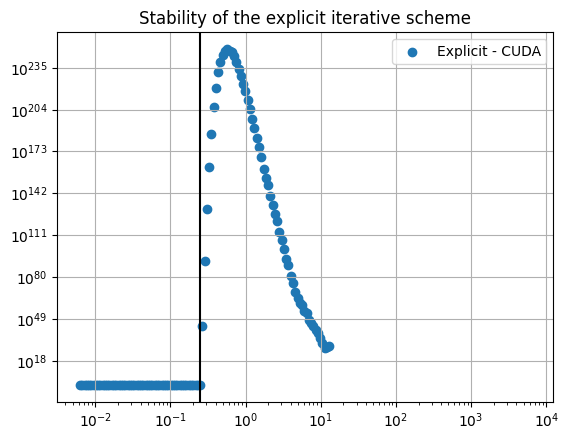

In [ ]:
stabmiddle = []
for i in stabulist:
  stabmiddle.append(i[int(len(i)/2)])

hn = 2/50
courantlist = np.array(dtlist)/(hn**2)
plt.scatter(courantlist, stabmiddle , label='Explicit - CUDA')
plt.axvline(x=0.25, c='k')
plt.title('Stability of the explicit iterative scheme')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()

#### Discussion
It can be clearly seen from the above plot of plate centre temperature vs $\frac{\Delta t}{h^2}$ (the Courant number) that the solution explodes as the Courant number approaches $0.25$ as $dt$ is increased from $1\times 10^{-6}$ to $1.$

For the explicit scheme to be stable, we require:
$$
C=\frac{\Delta t}{N^2}=\frac{\Delta t}{h^2}\cdot 4\leq 1
$$
where we substitute $h=\frac{2}{N}$

After rearranging we get:
$$
C\leq 0.25
$$
The explicit iterative scheme is conditionally stable, that is it remains stable for time step sizes $\Delta t$ below $0.25$. For larger $\Delta t$, the method becomes unstable, and the solution grows uncontrollably. 

Implicit iterative solutions tend to be unconditionally stable.

The backward Euler method is:

$$
(I - \Delta t A) u^{n+1} = u^n,
$$

The implicit method is stable because $(I-\Delta tA)$ shifts the eigenvalues of $A$ to positive values, preventing exponential growth.

# Conclusions

## Explicit Time-Stepping
- The stability is governed by the Courant-Friedrichs-Lewy (CFL) condition, requiring $C=\frac{\Delta t}{N^2}\leq 1$ for convergence. This constraint limits computational efficiency but ensures accurate results for sufficiently small $\Delta t$.
- The Courant number, $\Delta t \cdot \frac{N^2}{4}$, was used to monitor stability, demonstrating that exceeding this threshold ($C\leq 0.25$) leads to divergence.

### JIT vs CUDA Acceleration

#### JIT Compilation
JIT optimisation was used to accelerate Python code by pre-compiling critical sections during runtime.
- Advantages
    - Easy to implement, requiring minimal changes to existing Python code.
    - Provides significant speedups for CPU-bound tasks compared to standard Python execution.
- Limitations
    - Performance is limited by CPU capabilities.
    - Not suitable for leveraging GPU parallelism, which is critical for handling large-scale data or computations.

#### CUDA Acceleration
CUDA was employed to offload computational tasks to the GPU, enabling parallelism for matrix-vector operations and time-stepping schemes. In an attempt to limit CPU-GPU communications, we only check the temperature of the center of the plate after $0.42s$. In another version of the CUDA implementation, we carry out a large number of iterations on the GPU to cut down on the thousands of CPU-GPU communications that would ordinarily occur. This method, however, propagates massive errors which I believe is due to GPU threads not being synced properly and error-checking not being carried which would normally occur with regular CPU-GPU communications.

- Advantages
    - Outstanding performance for large-scale simulations, particularly for operations that benefit from parallel processing like the matrix-vector multiplication.
    - Handles larger grids $(N)$ and smaller time steps $(\Delta t)$ more efficiently than CPU-based JIT methods.
- Limitations
    - Requires explicit management of data transfer between CPU and GPU memory, which can introduce overheads.
    - Implementation complexity is higher compared to JIT, as it involves writing CUDA-specific code or using GPU-accelerated libraries.
    - Some weird limitiations on the grid size meant that $N$ coouldn't exceed 250.

### Performance
CUDA acceleration significantly outperformed JIT for larger grid sizes $(N)$ due to its ability to execute thousands of threads simultaneously. For smaller grids, the overhead of data transfer reduced CUDA’s performance advantage.
### Ease of Use
JIT required less effort to implement and adapt for smaller-scale problems. CUDA, while powerful, demanded a deeper understanding of GPU programming and efficient memory management.
### Scalability
CUDA demonstrated superior scalability, effectively handling larger computational loads without the stability or performance bottlenecks seen with JIT.

### Insights
For computational tasks involving large grid sizes or requiring high precision and efficiency, CUDA acceleration is the preferred method due to its ability to fully exploit GPU parallelism. JIT optimization, on the other hand, remains a viable choice for smaller-scale problems or where ease of implementation is critical. Both methods complement each other and can be chosen based on the specific needs of the simulation or application.


## Implicit Time-Stepping
   - The implicit scheme is unconditionally stable, allowing for much larger time steps than the explicit method. This makes it more computationally efficient for larger problems or long-term simulations.
   - The stability is achieved by solving a matrix equation $(I - \Delta t A) u^{n+1} = u^n$, where $I - \Delta t A$ is always invertible, ensuring convergence regardless of $\Delta t$.

## Key Insights
- The explicit scheme is suitable for scenarios requiring high accuracy over short time intervals but requires careful adherence to the CFL condition for stability.
- The implicit scheme is ideal for longer simulations or when computational efficiency is critical, as it remains stable for larger $\Delta t$, albeit at the cost of solving a linear system at each time step.
- Grid resolution $N$ plays a pivotal role in both methods, directly influencing accuracy and computational complexity.